# Advanced Machine Learning and Artificial Intelligence (MScA 32017)

# Project: Anomalies Detection using Autoencoders

## Notebook 5: Compare Autoencoder with Classifier. Complete code.

## Yuri Balasanov, Andrey Kobyshev, &copy; iLykei 2018-2020

This notebook compares anomalies detection by autoencoder and by classifier trained on one type of attack. Then both are tried on a different type of attack.

# Motivation

The main goal of this notebook is to show that autoencoder is a more universal method for anomaly detection than classifier because autoencoder is trained on data without anomalies, thus it can detect rare deviations from normal regardless of their type.

Unlike classifier autoencoder solution does not require labels for training, some limited number of labels may be useful only for validation. This means that autoencoder solution does not get affected by imbalanced classes, which is a typical challenge for classification of anomalies as rare events.

For comparison this notebook shows how to build a classifier - a neural network that is trained with labels to distinguish normal and anomaly classes (attack of type "ipsweep").

Dataset is the same as in <a href="https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE4_kddCup_Instructions.ipynb" target="_blank">MScA_32017_AMLAI_AE4_kddCup_Instructions.ipynb</a>

After training and testing classifier on one type of attack the same classifier will be checked on a different type of attack. For both classes of attack classifier will need to be compared with the autoencoder solution. Complete this comparison when autoencoder model is trained and saved to file.

Import the needed libraries.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support,
                             cohen_kappa_score, accuracy_score)
import sklearn.metrics as skm
from sklearn.linear_model import LogisticRegression
from pylab import rcParams
import pickle

In [ ]:
rcParams['figure.figsize'] = 14, 8
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Data

Read train dataset `kddCupTrain.csv` from `kddCupData.zip`:

In [ ]:
kddCupTrain = pd.read_csv('kddCupTrain.csv',header=None)

and prepare the data as described in <a href="https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE4_kddCup_Instructions.ipynb" target="_blank">MScA_32017_AMLAI_AE4_kddCup_Instructions.ipynb</a>, **except: do not separate the "normal" instances from the training dataset. Model will be trained on the entire dataset**.  

Note that the features list should be exactly the same as it was for an Autoencoder.

In [ ]:
# Skipped code
kddCupTrain.rename(columns={41:'Class'}, inplace=True)
kddCupTrain['Class'] = np.where(kddCupTrain['Class'] == 'normal.', 0, 1)

kddCupTrain.drop([7, 19], axis=1, inplace=True)
kddCupTrain = pd.get_dummies(kddCupTrain, columns = [1, 2, 3])


In [ ]:
featuresList = [col for col in kddCupTrain if col != 'Class']
kddCupTrain = kddCupTrain[featuresList + ['Class']]

#kddCupTrain.columns = kddCupTrain.columns.astype(str)
scaler = preprocessing.StandardScaler()
kddCupTrain[featuresList] = scaler.fit_transform(kddCupTrain[featuresList])
print(kddCupTrain.head(2))

          0         4         5         6         8         9        10  \
0 -0.159781 -0.010432 -0.080877 -0.002867 -0.002328 -0.052725 -0.007608   
1 -0.159781 -0.012213 -0.091406 -0.002867 -0.002328 -0.052725 -0.007608   

         11        12        13       14        15       16        17  \
0  0.638168 -0.004154 -0.017323 -0.00991 -0.006715 -0.02151 -0.018878   
1 -1.566985 -0.004154 -0.017323 -0.00991 -0.006715 -0.02151 -0.018878   

         18   20       21        22        23        24        25        26  \
0 -0.063652  0.0 -0.06214  0.165580 -0.000041 -0.054192 -0.065229 -0.245033   
1 -0.063652  0.0 -0.06214 -0.399407 -0.459327 -0.054192 -0.065229  4.108992   

         27        28        29        30        31        32        33  \
0 -0.247443  0.157112 -0.156338 -0.487066 -0.284497  0.612124  0.504541   
1  4.130226  0.157112 -0.156338 -0.487066 -1.399457  0.612124  0.504541   

         34        35        36        37        38        39        40  \
0 -0.312248 -0.

After all transformations the dataset should have format as follows:  
`print(kddCupTrain.head(2))`

`'       0         4         5        6         8         9        10  \
0 -0.16002 -0.011000 -0.081782 -0.00281 -0.002293 -0.052638 -0.007482   
1 -0.16002 -0.012928 -0.092466 -0.00281 -0.002293 -0.052638 -0.007482   `

`'       11        12        13        14        15        16        17  \
0  0.638870 -0.004254 -0.017549 -0.010038 -0.007049 -0.021138 -0.018912   
1 -1.565263 -0.004254 -0.017549 -0.010038 -0.007049 -0.021138 -0.018912   `

`'       18        20        21        22        23        24        25  \
0 -0.063614 -0.001502 -0.061903  0.165707  0.000046 -0.054189 -0.065417   
1 -0.063614 -0.001502 -0.061903 -0.399884 -0.459251 -0.054189 -0.065417   `

`'       26        27        28        29        30        31        32  \
0 -0.244655 -0.247066  0.157689 -0.156892 -0.486813 -0.285323  0.612755   
1  4.115563  4.137151  0.157689 -0.156892 -0.486813 -1.400495  0.612755   `

`'       33       34        35        36        37        38        39  \
0  0.504939 -0.31261 -0.456592 -0.249604 -0.070939  0.590035 -0.257053   
1  0.504939 -0.31261  2.893958  0.327044 -0.070939 -0.067872  4.180321   `

`'       40    1_icmp     1_tcp     1_udp     2_IRC     2_X11    2_auth  \
0 -0.255692 -0.159083  0.529347 -0.490912 -0.023004 -0.011634 -0.048641   
1  4.251843 -0.159083  0.529347 -0.490912 -0.023004 -0.011634 -0.048641   `

`'    2_ctf  2_domain  2_domain_u   2_eco_i   2_ecr_i  2_finger    2_ftp  \
0 -0.003679 -0.006882    -0.24971 -0.125649 -0.059192 -0.071618 -0.06236   
1 -0.003679 -0.006882    -0.24971 -0.125649 -0.059192 -0.071618 -0.06236   `

`' 2_ftp_data  2_gopher   2_http   2_imap4    2_link     2_mtp    2_name  \
0   -0.200526 -0.003679  0.76902 -0.001839 -0.003829 -0.003522 -0.003829   
1   -0.200526 -0.003679  0.76902 -0.001839 -0.003829 -0.003522 -0.003829   `

`'  2_ntp_u   2_other   2_pop_3  2_private   2_red_i  2_remote_job     2_rje  \
0 -0.062415 -0.246557 -0.030349  -0.286053 -0.003186     -0.003522 -0.003679   
1 -0.062415 -0.246557 -0.030349  -0.286053 -0.003186     -0.003522 -0.003679   `

`'  2_shell    2_smtp     2_ssh  2_telnet  2_tftp_u  2_tim_i    2_time  \
0 -0.002375 -0.327462 -0.004749 -0.047641 -0.001839 -0.00281 -0.023248   
1 -0.002375 -0.327462 -0.004749 -0.047641 -0.001839 -0.00281 -0.023248`   

`` 2_urh_i   2_urp_i   2_whois     3_OTH     3_REJ    3_RSTO    3_RSTR  \
0 -0.01234 -0.074221 -0.003358 -0.003679 -0.241512 -0.025561 -0.018488   
1 -0.01234 -0.074221 -0.003358 -0.003679  4.140580 -0.025561 -0.018488`

`'     3_S0      3_S1      3_S2    3_S3      3_SF      3_SH  Class  
0 -0.020706 -0.022906 -0.012476 -0.0068  0.246491 -0.001062      0  
1 -0.020706 -0.022906 -0.012476 -0.0068 -4.056951 -0.001062      0`  

In [ ]:
# Save the prepared data to the file:

pickle.dump(kddCupTrain, open('prepared_kddCupTrain.sav', 'wb'))

In [ ]:
# Load the prepared data from the file:
kddCupTrain = pickle.load(open('/prepared_kddCupTrain.sav', 'rb'))

# Building Classifier

Input layer of the classifier has the same shape as the Autoencoder.  
The output layer has single unit.

Select number and dimentions of hidden layers. The model should not be too complex. One or two hidden layers is enough.

In [ ]:
input_dim = len(featuresList)
input_layer = Input(shape=(input_dim, ))
classifier = Dense(11, activation='relu')(input_layer)
classifier = Dropout(0.5)(classifier)
classifier = Dense(1, activation='sigmoid')(classifier)
classModel = Model(inputs=input_layer, outputs=classifier)
classModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 83)]              0         
                                                                 
 dense (Dense)               (None, 11)                924       
                                                                 
 dropout (Dropout)           (None, 11)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 12        
                                                                 
Total params: 936 (3.66 KB)
Trainable params: 936 (3.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Split the dataset to the train and test subsets:  

In [ ]:
train, test = train_test_split(kddCupTrain,
                               test_size=0.2,
                               shuffle=True,
                               stratify=kddCupTrain['Class'],
                               random_state=1)

Fit the model using following arguments of function `fit()`:

`x = train[featuresList],
y = train['Class'],
validation_data=(test[featuresList], test['Class'])`  

Experiment with parameters like: `epochs`, `batch_size`, `callbacks` ets.

In [ ]:
nb_epoch = 50
batch_size = 256
adam = Adam(lr=0.0005)
classModel.compile(optimizer=adam,
                    loss='mean_squared_error')

earlystopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0)
checkpointer = ModelCheckpoint(filepath="classifier.h5",
                               verbose=0,
                               save_best_only=True)

class_history = classModel.fit(x=train[featuresList], y=train['Class'],
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test[featuresList], test['Class']),
                    verbose=1,
                    callbacks=[earlystopping, checkpointer]).history

Epoch 1/50
2280/2282 [============================>.] - ETA: 0s - loss: 0.0272

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2282/2282 [==============================] - 14s 6ms/step - loss: 0.0272 - val_loss: 0.0015
Epoch 2/50
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0058 - val_loss: 0.0011
Epoch 3/50
2282/2282 [==============================] - 8s 4ms/step - loss: 0.0032 - val_loss: 0.0010
Epoch 4/50
2282/2282 [==============================] - 6s 3ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 5/50
2282/2282 [==============================] - 6s 3ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 6/50
2282/2282 [==============================] - 5s 2ms/step - loss: 0.0023 - val_loss: 9.9856e-04
Epoch 7/50
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0024 - val_loss: 0.0010


# Explain

### LIME

In [ ]:
import lime
import lime.lime_tabular
import numpy as np
from keras.models import load_model
classModel = load_model("classifier.h5")
kddCupTrain = pickle.load(open('prepared_kddCupTrain.sav', 'rb'))
kddCupTest = pickle.load(open('prepared_kddCupTest.sav', 'rb'))

In [ ]:
# Drop the class column
X_train_features = kddCupTrain.drop(columns=['Class']).values
X_test_features = kddCupTest.drop(columns=['Class']).values


157/157 [==============================] - 0s 1ms/step


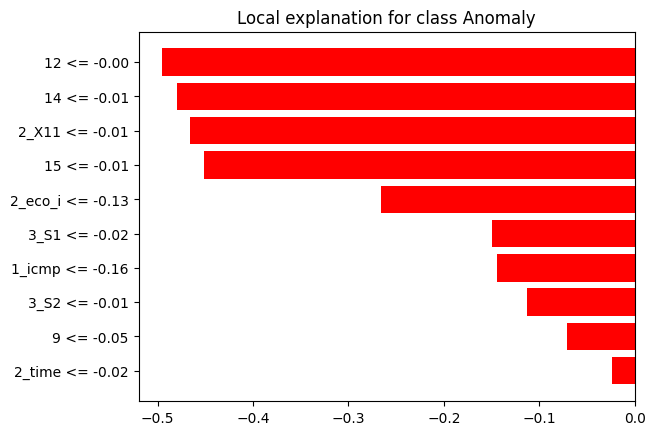

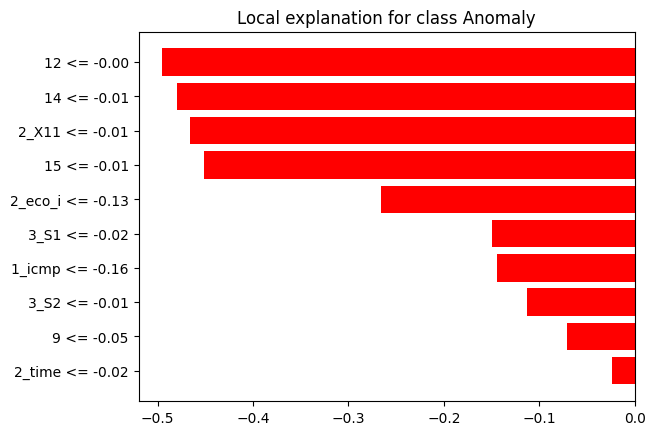

In [ ]:
def predict_proba(X):
    preds = classModel.predict(X)
    return np.hstack((1 - preds, preds))  # Ensure it's in two-column format for binary classification

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_features,
    feature_names=featuresList,  # Correct feature names list
    class_names=['Normal', 'Anomaly'],  # Modify according to your class names
    mode='classification'
)

i = 0  # Index of the instance to explain
exp = explainer.explain_instance(
    data_row=X_test_features[i],
    predict_fn=predict_proba,
    num_features=10  # Number of features to show in the explanation
)

# Display the explanation
exp.show_in_notebook(show_table=True, show_all=False)
exp.as_pyplot_figure()

The bar chart uses LIME to interpret the model's predictions for the "Anomaly" class. In this case, LIME has identified the features contributing most to the classification as an Normal, since all bar with negative value.

### SHAP

In [ ]:
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 5.2 MB/s eta 0:00:00


In [ ]:
from keras.models import load_model
classModel = load_model("classifier.h5")
kddCupTrain = pickle.load(open('prepared_kddCupTrain.sav', 'rb'))
kddCupTest = pickle.load(open('prepared_kddCupTest.sav', 'rb'))
X_test_adjusted = kddCupTest[:, :83]

In [ ]:
import numpy as np

# Randomly select 100 samples from X_test_adjusted
sample_indices = np.random.choice(X_test_adjusted.shape[0], 100, replace=False)
X_test_sample = X_test_adjusted[sample_indices]


In [ ]:
import shap
import matplotlib.pyplot as plt

masker = shap.maskers.Independent(X_test_sample)
explainer = shap.Explainer(classModel, masker)
shap_values = explainer(X_test_sample)


PermutationExplainer explainer: 101it [00:16,  2.11it/s]


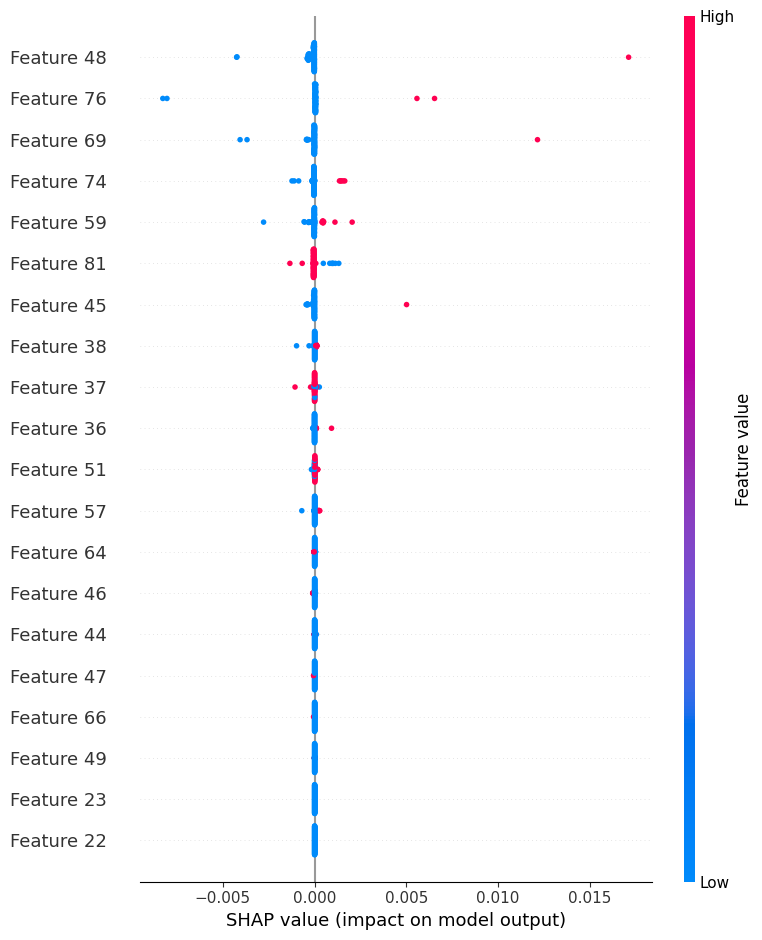

In [ ]:
shap.summary_plot(shap_values, X_test_sample)


- Feature Impact: Features with larger spreads in SHAP values (like Feature 48 and Feature 76) have a more significant impact on the model's predictions.
- Positive and Negative Influence: If the SHAP values for a feature are mostly on one side of zero, this feature tends to push predictions consistently in one direction.
- Feature Value Influence: The color gradient shows how the feature value relates to the impact. For instance, if high feature values (red) are associated with high SHAP values (positive impact), this feature increases the prediction when its value is high.

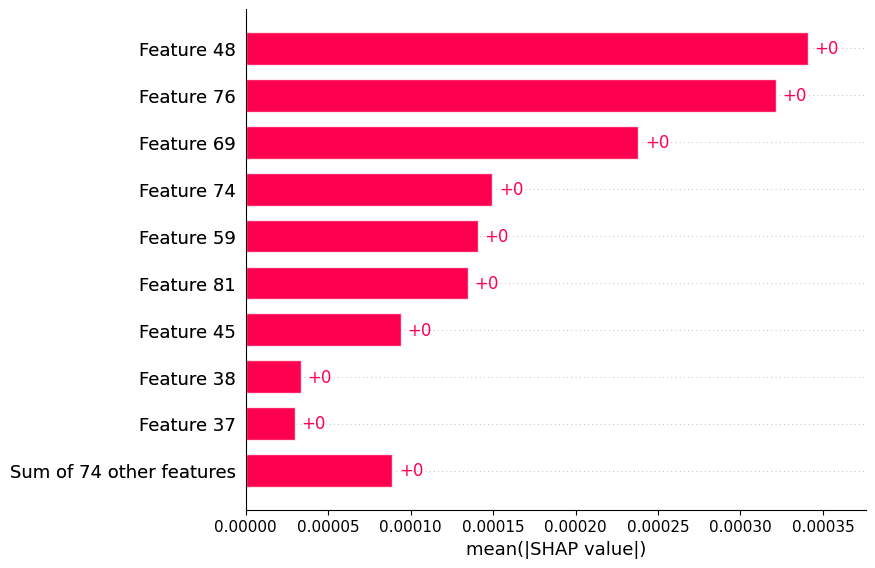

In [ ]:
shap.plots.bar(shap_values)


### Layer-wise Relevance Propagation (LRP)


In [ ]:
!pip install innvestigate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: ten

In [ ]:
import innvestigate
import innvestigate.utils as iutils
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import pickle

classModel = load_model("classifier.h5")
kddCupTrain = pickle.load(open('prepared_kddCupTrain.sav', 'rb'))
kddCupTest = pickle.load(open('prepared_kddCupTest.sav', 'rb'))


In [ ]:
# Drop the class column
X_train_features = kddCupTrain.drop(columns=['Class']).values
X_test_features = kddCupTest.drop(columns=['Class']).values
featuresList = [col for col in kddCupTrain if col != 'Class']

In [ ]:
import tensorflow as tf
from keras.models import Model, load_model

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Recreate the model without the softmax layer
input_layer = classModel.input
output_layer = classModel.layers[-1].output
simple_model = Model(inputs=input_layer, outputs=output_layer)

# Create an analyzer
analyzer = innvestigate.create_analyzer("lrp.z", simple_model)

# Select some samples for explanation
samples = kddCupTest[featuresList].values[:5]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


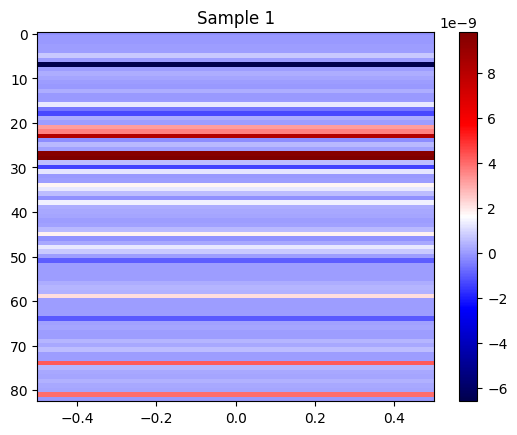

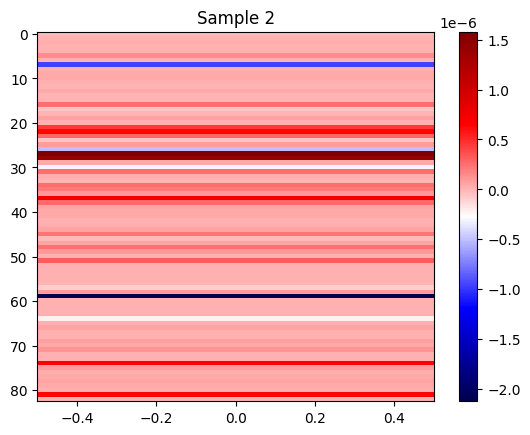

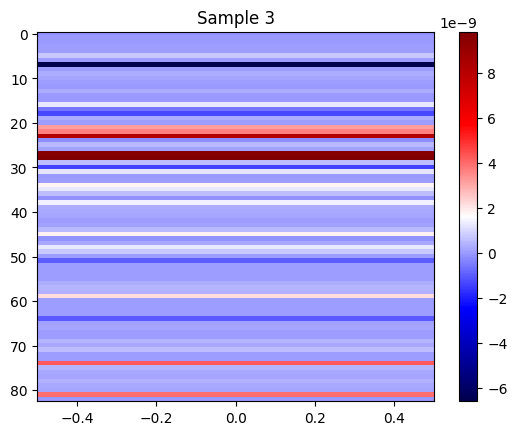

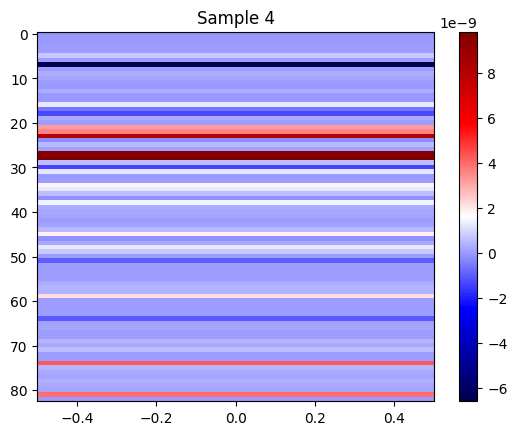

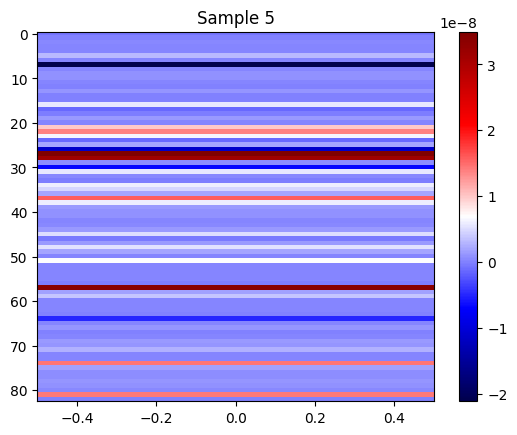

In [ ]:
import sys

# Increase the recursion limit
sys.setrecursionlimit(100000)

# Apply the analyzer
analysis = analyzer.analyze(samples)

# Visualize the results
for i in range(len(samples)):
    plt.figure()
    plt.title(f"Sample {i + 1}")
    plt.imshow(analysis[i].reshape((len(featuresList), 1)), aspect='auto', cmap='seismic')
    plt.colorbar()
    plt.show()


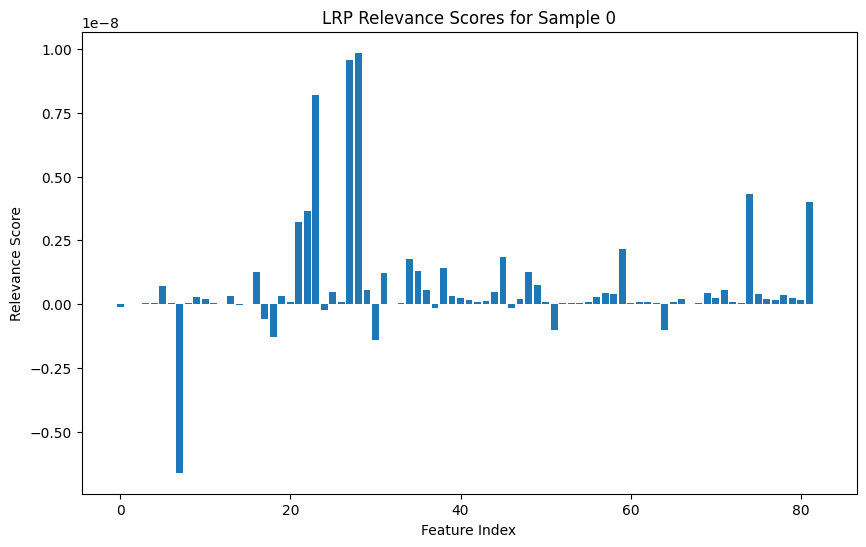

In [ ]:
# For demonstration, let's take the first sample's relevance scores
relevance_scores = analysis[0]

# Plot the relevance scores as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(relevance_scores)), relevance_scores)
plt.xlabel('Feature Index')
plt.ylabel('Relevance Score')
plt.title('LRP Relevance Scores for Sample 0')
plt.show()

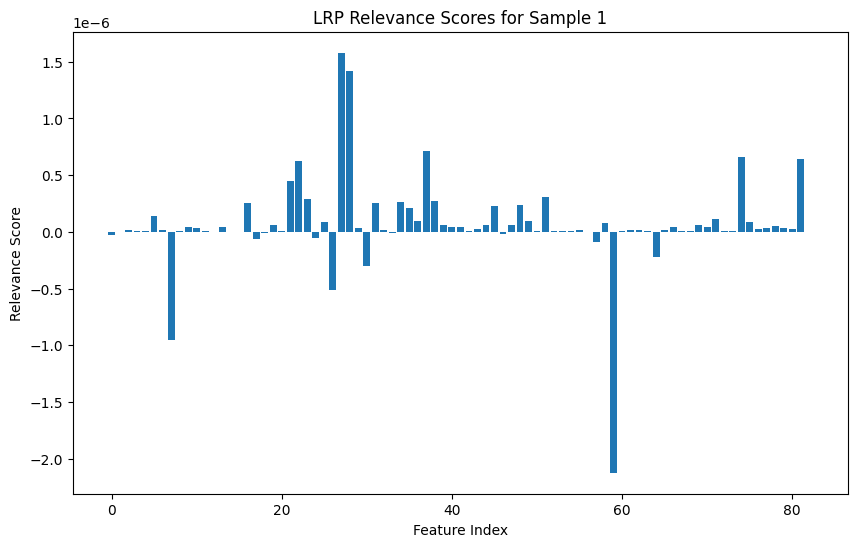

In [ ]:
# For demonstration, let's take the first sample's relevance scores
relevance_scores = analysis[1]

# Plot the relevance scores as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(relevance_scores)), relevance_scores)
plt.xlabel('Feature Index')
plt.ylabel('Relevance Score')
plt.title('LRP Relevance Scores for Sample 1')
plt.show()

# Evaluating Classifier

Load the model saved by `ModelCheckpoint`:

In [ ]:
fittedClassifier = load_model('classifier.h5')

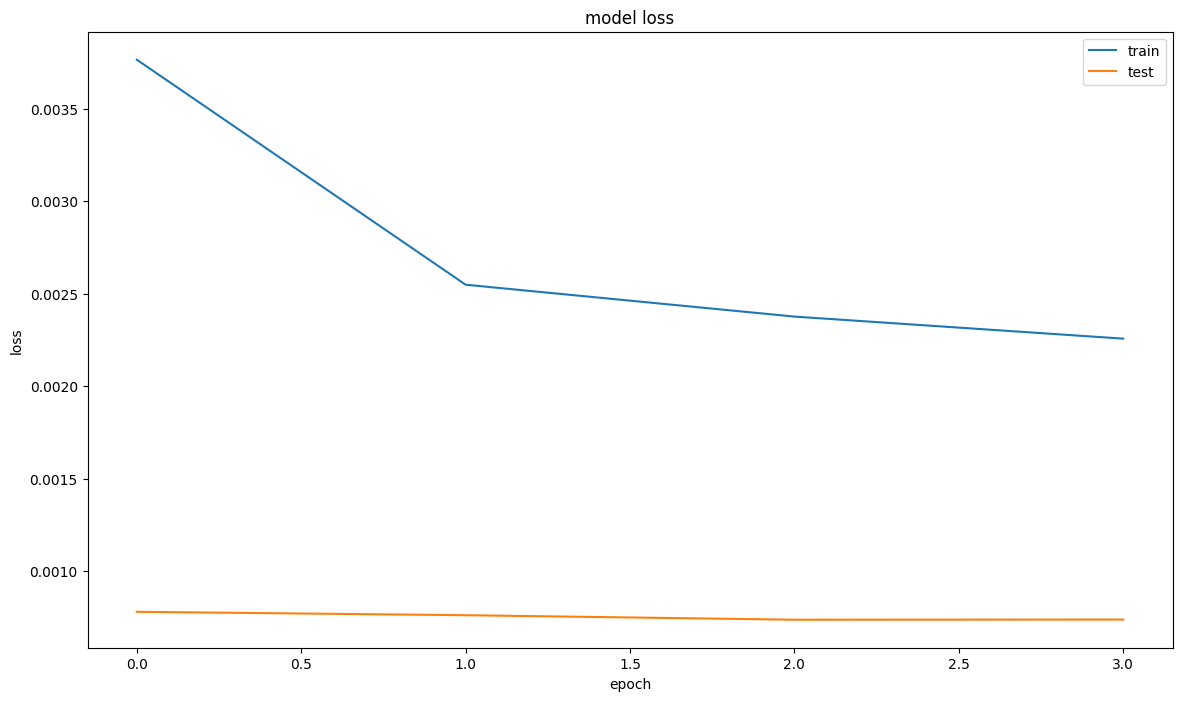

In [ ]:
# Look at the fitting history:
plt.plot(class_history['loss'])
plt.plot(class_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

Using this model make prediction for the validation dataset:  

In [ ]:
testProb = fittedClassifier.predict(test[featuresList])

4563/4563 [==============================] - 10s 2ms/step


Interpret `testProb` as confidence in detection of attacks.  
Create a dataframe with "predicted probabilities" and "true class" columns.  

In [ ]:
testProb = testProb[:,0]
class_prob_df = pd.DataFrame({'probabilities': testProb,
                        'true_class': test['Class']})

Construct the ROC curve and calculate AUC value in the same way as in [FMScA_32017_AMLAI_AE3_FraudDetection.ipynb](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE3_FraudDetection.ipynb).

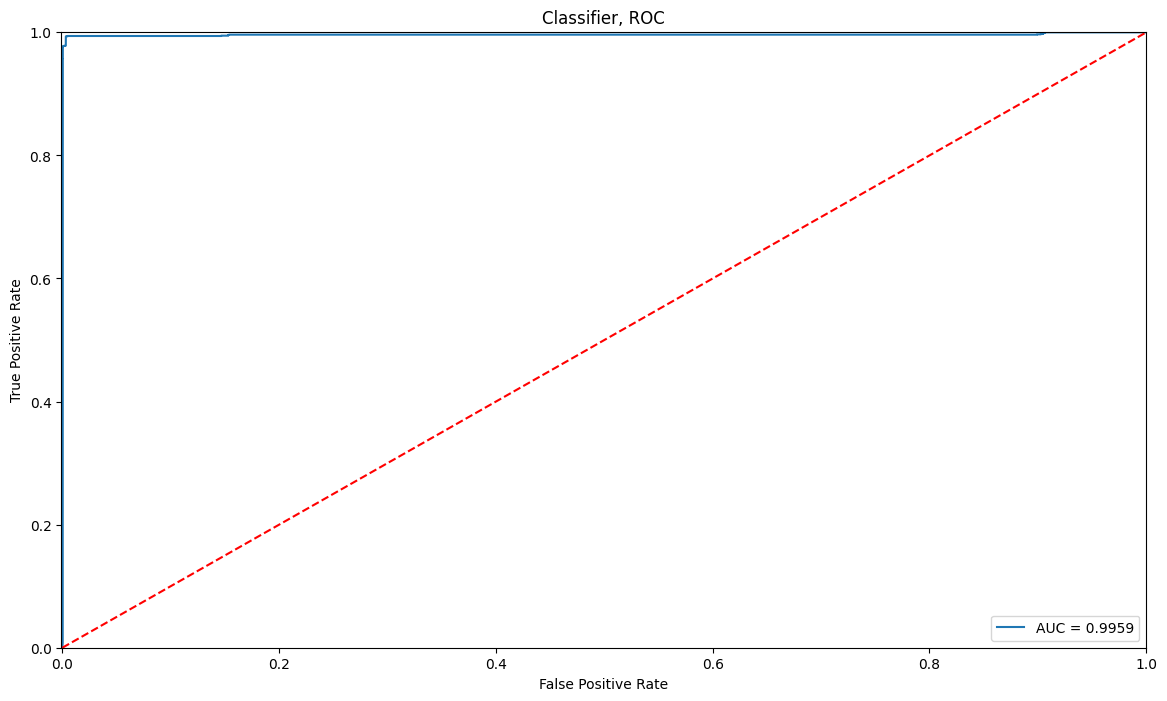

In [ ]:
#Skipped code

fpr, tpr, thresholds = roc_curve(class_prob_df.true_class, class_prob_df.probabilities)
roc_auc = auc(fpr, tpr)

plt.title('Classifier, ROC')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Plot the predicted probabilities of normal and attack classes (see [FMScA_32017_AMLAI_AE3_FraudDetection.ipynb](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE3_FraudDetection.ipynb) for example of graph).  

Select a threshold for predicting class from probability.

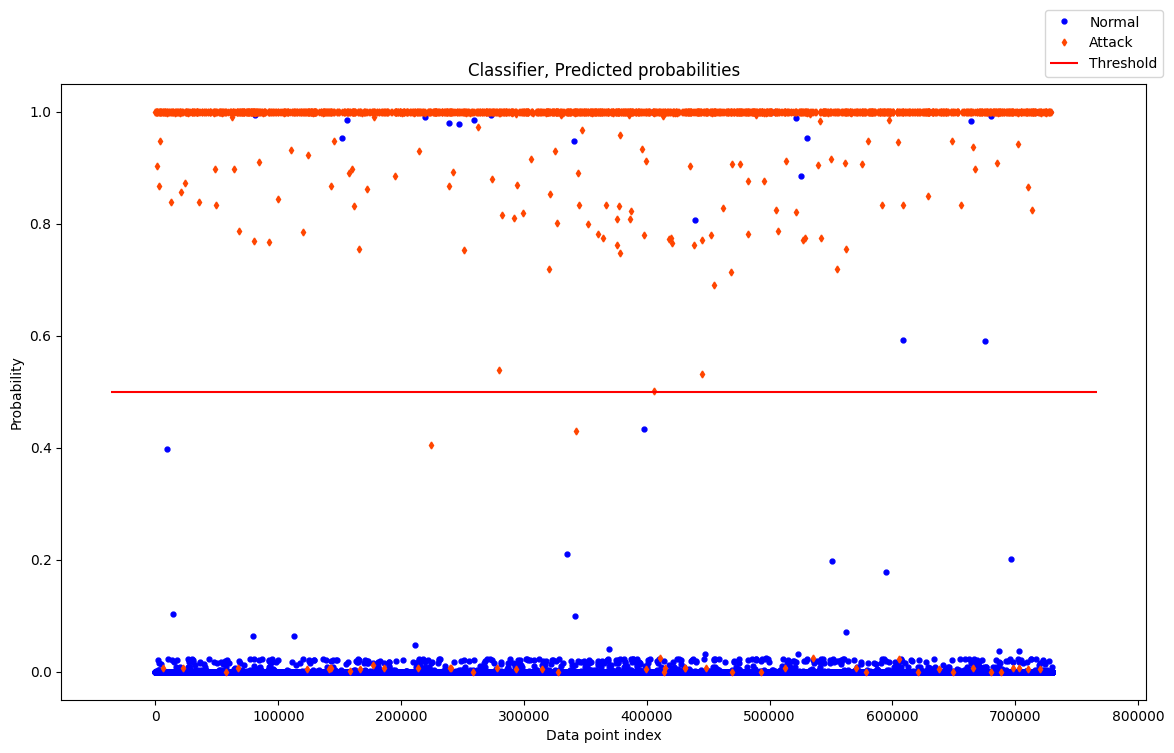

In [ ]:
class_threshold = 0.5
groups = class_prob_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    if name == 1:
        MarkerSize = 3.5
        Color = 'orangered'
        Label = 'Attack'
        Marker = 'd'
    else:
        MarkerSize = 3.5
        Color = 'b'
        Label = 'Normal'
        Marker = 'o'
    ax.plot(group.index, group.probabilities,
            linestyle='',
            color=Color,
            label=Label,
            ms=MarkerSize,
            marker=Marker)
ax.hlines(class_threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend(bbox_to_anchor=(0.9, 1))
plt.title("Classifier, Predicted probabilities")
plt.ylabel("Probability")
plt.xlabel("Data point index")
plt.show();

Plot the confusion matrix for the selected threshold (see [FMScA_32017_AMLAI_AE3_FraudDetection.ipynb](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE3_FraudDetection.ipynb) for example).

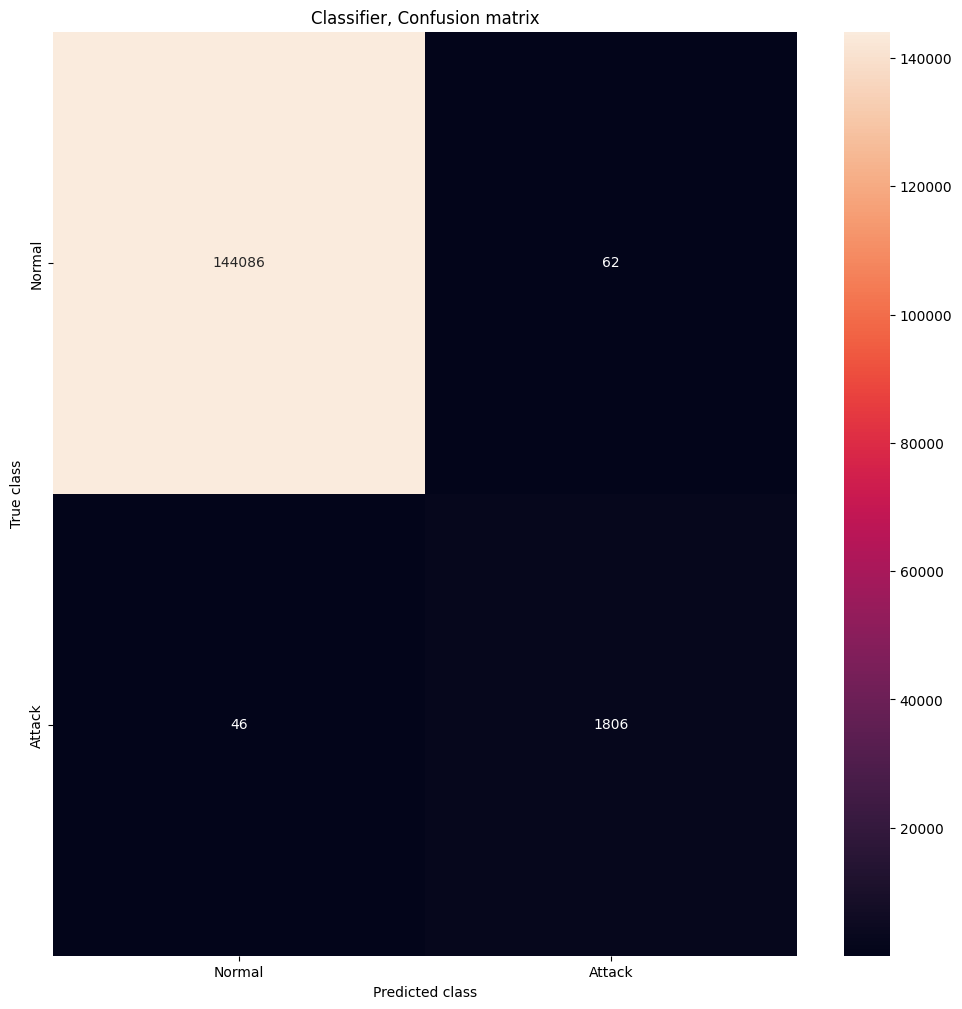

In [ ]:
# Skipped code

LABELS = ["Normal", "Attack"]
y_pred = [1 if e > class_threshold else 0 for e in class_prob_df.probabilities.values]
conf_matrix = confusion_matrix(class_prob_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Classifier, Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Calculate Accuracy and Cohen's Kappa (like in [FMScA_32017_AMLAI_AE3_FraudDetection.ipynb](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE3_FraudDetection.ipynb)).

In [ ]:
print("Cohen's Kappa = ", cohen_kappa_score(class_prob_df.true_class, y_pred))
print("Accuracy = ", accuracy_score(class_prob_df.true_class, y_pred))

Cohen's Kappa =  0.9705931131846157
Accuracy =  0.9992602739726028


This is the quality of the trained classifier for detecting attack of type "ipsweep"

# Compare the Classifier and the Autoencoder on the validation dataset

Load the trained Autoencoder Model that has been saved in section 2.2. of [MScA_32017_AMLAI_AE4_kddCup_Instructions.ipynb](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE4_kddCup_Instructions.ipynb).  

In [ ]:
fittedAutoencoder = load_model('./Saved_Files/autoencoder.h5')

OSError: No file or directory found at ./Saved_Files/autoencoder.h5

Reproduce the validation dataset, calculate the mean squared error of the reconstruction ([FMScA_32017_AMLAI_AE3_FraudDetection.ipynb](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE3_FraudDetection.ipynb)).  

In [ ]:
aePredictions = fittedAutoencoder.predict(test[featuresList])
mse = skm.mean_squared_error(test[featuresList].transpose(),
                             aePredictions.transpose(),
                             multioutput='raw_values')
ae_error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': test['Class']})

NameError: name 'fittedAutoencoder' is not defined

Construct a ROC curve for the reconstruction error and the labels of the `test` dataset.  
Calculate AUC value.  

In [ ]:
fpr, tpr, thresholds = roc_curve(ae_error_df.true_class, ae_error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Autoencoder, ROC')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Select a high level quantile of the MSE sample as a threshold for the attack detection.
Plot the reconstruction error for different classes.

In [ ]:
quantileLevel = 0.99
ae_threshold = ae_error_df[ae_error_df.true_class==0].reconstruction_error.quantile(q=quantileLevel)
ae_threshold

In [ ]:
groups = ae_error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    if name == 1:
        MarkerSize = 3.5
        Color = 'orangered'
        Label = 'Attack'
        Marker = 'd'
    else:
        MarkerSize = 3.5
        Color = 'b'
        Label = 'Normal'
        Marker = 'o'
    ax.plot(group.index, group.reconstruction_error,
            linestyle='',
            color=Color,
            label=Label,
            ms=MarkerSize,
            marker=Marker)
ax.hlines(ae_threshold, ax.get_xlim()[0], ax.get_xlim()[1],
          colors="r", zorder=100, label='Threshold')
ax.legend(bbox_to_anchor=(0.9, 1))
plt.title("Autoencoder, Reconstruction error")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.ylim([0,20])
plt.show();

Plot confusion matrix for the selected threshold.  

In [ ]:
y_pred = [1 if e > ae_threshold else 0 for e in ae_error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(ae_error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Autoencoder, Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Calculate Accuracy and Cohen's Kappa.

In [ ]:
print("Cohen's Kappa = ", cohen_kappa_score(ae_error_df.true_class, y_pred))
print("Accuracy = ", accuracy_score(ae_error_df.true_class, y_pred))

Note that classifier gives better results on the validation dataset.  

Compare both methods using new test data containing another type of anomaly: "portsweep".  

# Test Dataset with Different Class of Attack

Read test dataset from file ['kddCup_TestForClassifier.csv'](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FkddCup_TestForClassifier.zip) and check it for missing values.

In [ ]:
kddCupTest = pd.read_csv('kddCup_TestForClassifier.csv', header=None)
print("Shape of kddCupTest: ",kddCupTest.shape)
print("There are any missing values: ", kddCupTest.isnull().values.any())
print(kddCupTest.head(6))

NameError: name 'pd' is not defined

`kddCupTest` contains labels, so it is possible to compare quality of predictions by different models.  

The label column (**"41"**) contains 0 for "normal" connections and 1 for attacks.  
Rename column **"41"** to **"Class"**.  

In [ ]:
kddCupTest.rename(columns={41:'Class'}, inplace=True)

Transform the test data like in [MScA_32017_AMLAI_AE4_kddCup_Instructions.ipynb](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE4_kddCup_Instructions.ipynb).

Note that this time there is the label column in the test dataset.  

In [ ]:
# Skipped code
kddCupTest = pd.get_dummies(kddCupTest, columns = [1, 2, 3])
missing_cols = set(featuresList) - set(kddCupTest.columns.drop('Class'))
missing_cols

{'0',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '2_name',
 '2_red_i',
 '2_shell',
 '2_tftp_u',
 '2_tim_i',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '5',
 '6',
 '8',
 '9'}

In [ ]:
# Skipped code
# Prepare the test data
for c in missing_cols:
    kddCupTest[c] = 0
kddCupTest = kddCupTest[featuresList + ['Class']]
kddCupTest[featuresList] = scaler.transform(kddCupTest[featuresList])

After all transformations `kddCupTest` should have exactly same columns list as `kddCupTrain`.

In [ ]:
# Save the prepared data to the file:
pickle.dump(kddCupTest, open('prepared_kddCupTest.sav', 'wb'))

In [ ]:
kddCupTest = pickle.load(open('prepared_kddCupTest.sav', 'rb'))

## Predict Using Classifier and Autoencoder

Make predictions for `kddCupTest` using `fittedClassifier` and `fittedAutoencoder`.

Calculate AUC for both models and construct plots of AUC. errors and confusion table as was done for the validation dataset.

Use same thresholds as selected for the validation data.
Calculate Accuracy and Cohen's Kappa for both models.  

Make prediction using fittedClassifier

In [ ]:
testProb = fittedClassifier.predict(kddCupTest[featuresList])
testProb = testProb[:,0]
new_class_prob_df = pd.DataFrame({'probabilities': testProb,
                        'true_class': kddCupTest['Class']})

3072/3072 [==============================] - 6s 2ms/step


Construct the ROC curve and calculate AUC for the classifier

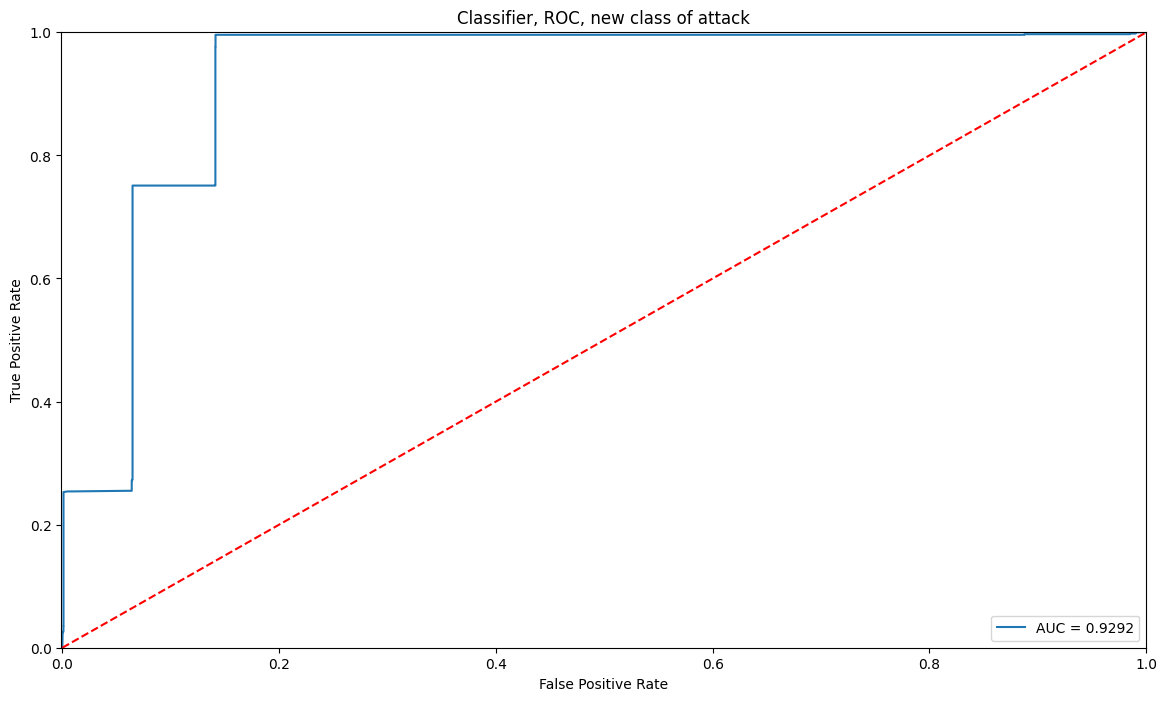

In [ ]:
# Construct the ROC curve and calculate AUC for the classifier
fpr, tpr, thresholds = roc_curve(new_class_prob_df.true_class, new_class_prob_df.probabilities)
roc_auc = auc(fpr, tpr)

plt.title('Classifier, ROC, new class of attack')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Plot the predicted probabilities of classes.  

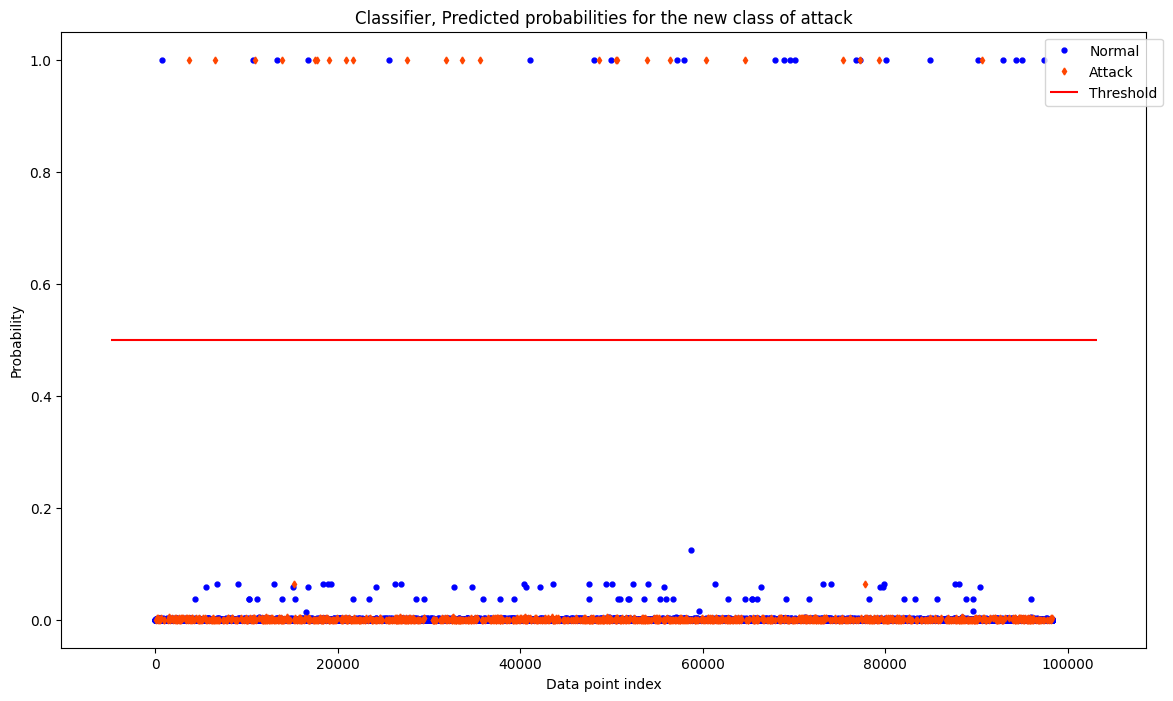

In [ ]:
groups = new_class_prob_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    if name == 1:
        MarkerSize = 3.5
        Color = 'orangered'
        Label = 'Attack'
        Marker = 'd'
    else:
        MarkerSize = 3.5
        Color = 'b'
        Label = 'Normal'
        Marker = 'o'
    ax.plot(group.index, group.probabilities,
            linestyle='',
            color=Color,
            label=Label,
            ms=MarkerSize,
            marker=Marker)
ax.hlines(class_threshold, ax.get_xlim()[0], ax.get_xlim()[1],
          colors="r", zorder=100, label='Threshold')
#ax.set_ybound(lower=0,upper=0.0003)
ax.legend(bbox_to_anchor=(0.9, 1))
plt.title("Classifier, Predicted probabilities for the new class of attack")
plt.ylabel("Probability")
plt.xlabel("Data point index")
plt.show();

Plot the confusion matrix for the threshold selected for the training dataset.  

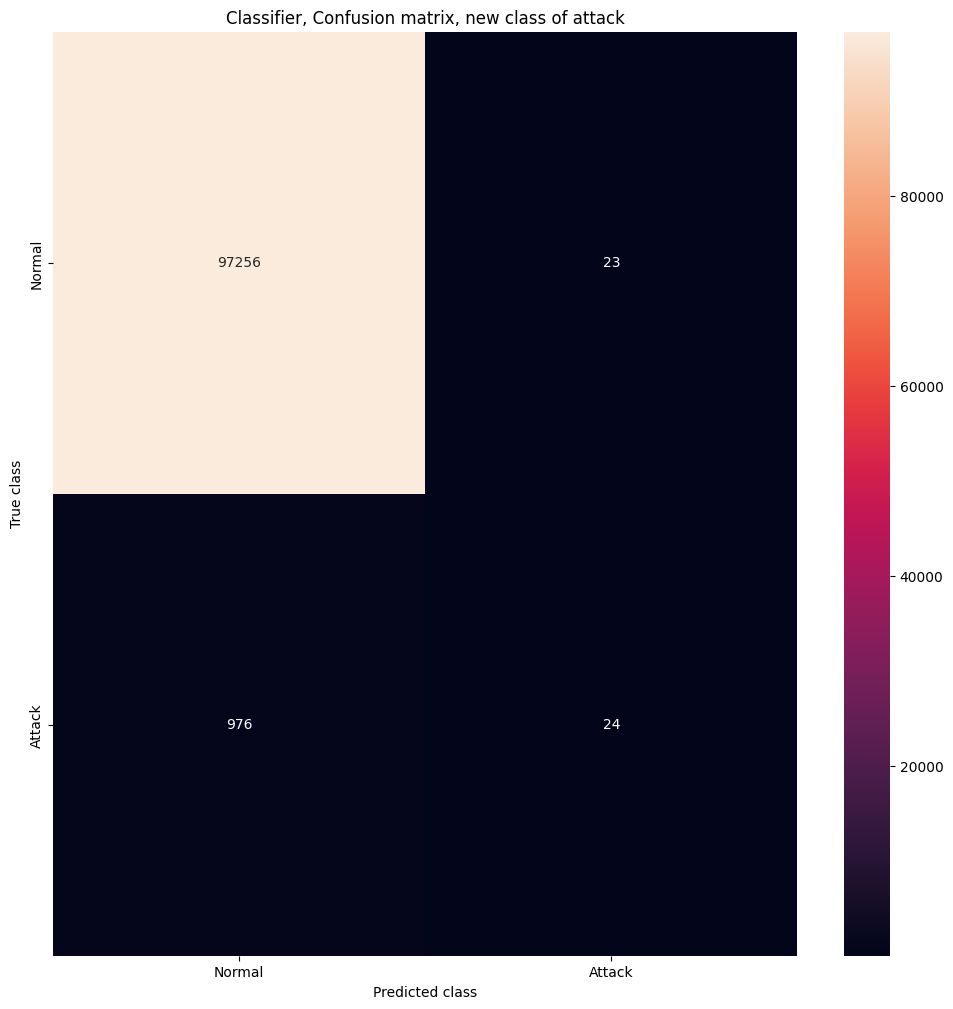

In [ ]:
y_pred = [1 if e > class_threshold else 0 for e in new_class_prob_df.probabilities.values]
conf_matrix = confusion_matrix(new_class_prob_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Classifier, Confusion matrix, new class of attack")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Calculate Accuracy and Cohen's Kappa.

In [ ]:
print("Cohen's Kappa = ", cohen_kappa_score(new_class_prob_df.true_class, y_pred))
print("Accuracy = ", accuracy_score(new_class_prob_df.true_class, y_pred))

Cohen's Kappa =  0.04497283099947558
Accuracy =  0.9898350614068112


Reconstruct the test dataset using `fittedAutoencoder`, calculate the mean squared error of the reconstruction.  

In [ ]:
aePredictions = fittedAutoencoder.predict(kddCupTest[featuresList])
mse = skm.mean_squared_error(kddCupTest[featuresList].transpose(),
                             aePredictions.transpose(),
                             multioutput='raw_values')
new_ae_error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': kddCupTest['Class']})

NameError: name 'fittedAutoencoder' is not defined

Construct the ROC curve and calculate AUC for the autoencoder

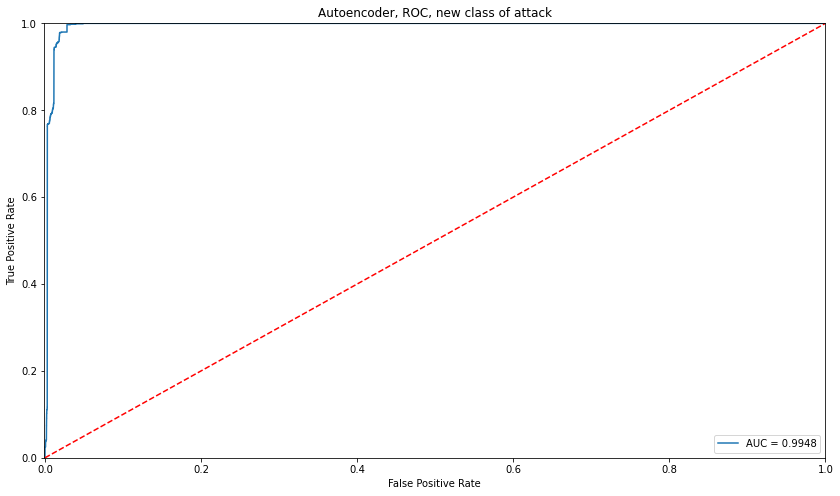

In [ ]:
fpr, tpr, thresholds = roc_curve(new_ae_error_df.true_class, new_ae_error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Autoencoder, ROC, new class of attack')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Plot the reconstruction error for different classes.  

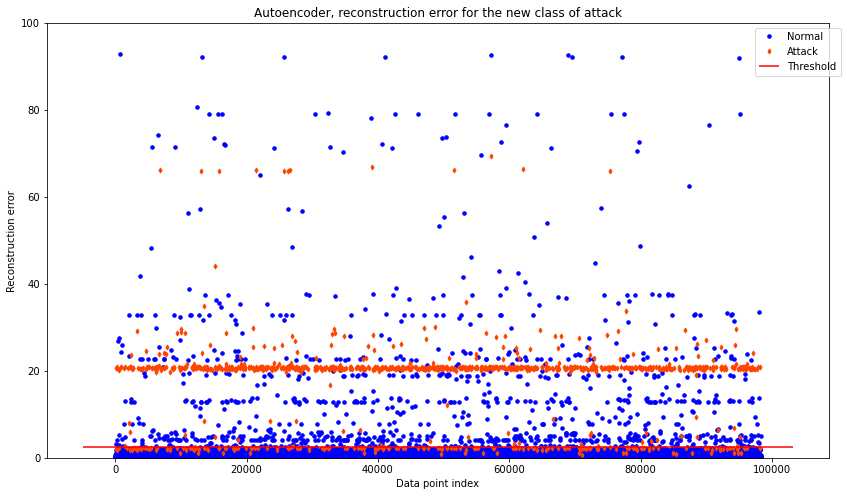

In [ ]:
groups = new_ae_error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    if name == 1:
        MarkerSize = 3.5
        Color = 'orangered'
        Label = 'Attack'
        Marker = 'd'
    else:
        MarkerSize = 3.5
        Color = 'b'
        Label = 'Normal'
        Marker = 'o'
    ax.plot(group.index, group.reconstruction_error,
            linestyle='',
            color=Color,
            label=Label,
            ms=MarkerSize,
            marker=Marker)
ax.hlines(ae_threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend(bbox_to_anchor=(0.9, 1))
plt.title("Autoencoder, reconstruction error for the new class of attack")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.ylim(0, 100)
plt.show();

Plot the confusion matrix for the threshold selected for the training dataset.  

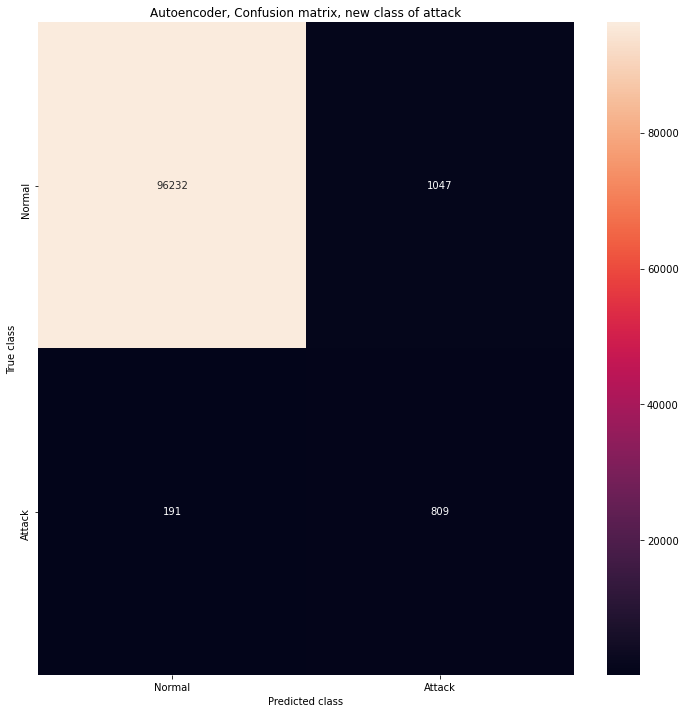

In [ ]:
y_pred = [1 if e > ae_threshold else 0 for e in new_ae_error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(new_ae_error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Autoencoder, Confusion matrix, new class of attack")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Calculate Accuracy and Cohen's Kappa.

In [ ]:
# Skipped code

print("Cohen's Kappa = ", cohen_kappa_score(new_ae_error_df.true_class, y_pred))
print("Accuracy = ", accuracy_score(new_ae_error_df.true_class, y_pred))

Cohen's Kappa =  0.5607171842967525
Accuracy =  0.9874032092308631


Quality of the Classifier is worse on another type of attack